In [4]:
import pandas as pd
import sys

sys.path.append('~/PycharmProjects/Boston_housing/')

df_master = pd.read_csv('./data/raw/' + 'redfin_2020-01-19-08-17-26.csv')
df_master.pop('SOLD DATE')
df_condo = pd.read_csv('./data/processed/' + 'Boston_condo_transaction.csv',index_col=0)
df_sfr = pd.read_csv('./data/processed/' + 'Boston_single_family_residential_transaction.csv',index_col=0)
df_townhouse = pd.read_csv('./data/processed/' + 'Boston_townhouse_transaction.csv',index_col=0)

df_transaction = pd.concat([df_condo,df_sfr,df_townhouse])

df = df_master.join(df_transaction,how='inner')


# Drop outlier that is beyond the Q3+1.5*IQR

Justify the drop. How many of them are due to typo and how many are genuine?

number of data before outlier removal:  7912
number of data after outlier removal:  6048
number of data after removing new data:  6046


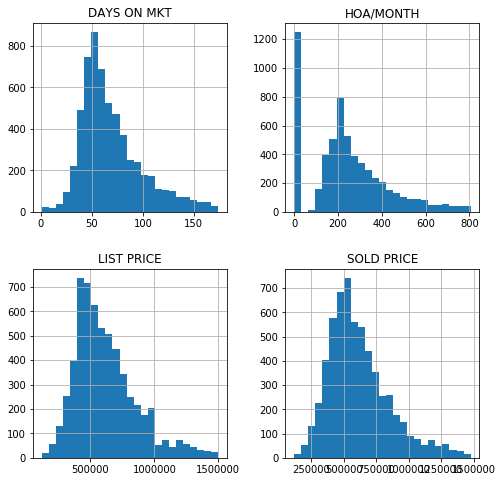

In [6]:
import numpy as np

def upper_outlier(x):
    return  np.quantile(x,0.75) + 1.5*(np.quantile(x,0.75)-np.quantile(x,0.25))

def lower_outlier(x):
    return  np.quantile(x,0.25) - 1.5*(np.quantile(x,0.75)-np.quantile(x,0.25))

df['SOLD DATE'] = pd.to_datetime(df['SOLD DATE'])
df['LIST DATE'] = pd.to_datetime(df['LIST DATE'])
df['DAYS ON MKT'] = (df['SOLD DATE'] - df['LIST DATE']).apply(lambda x: x.days)
df['HOA/MONTH'] = df['HOA/MONTH'].fillna(0)
df['PREMIUM'] = (df['SOLD PRICE'] - df['LIST PRICE'])/df['LIST PRICE']

df_upper_outlier = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH','PREMIUM']].apply(
    lambda x: upper_outlier(x),axis=0)
df_lower_outlier = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH','PREMIUM']].apply(
    lambda x: lower_outlier(x),axis=0)

print('number of data before outlier removal: ',len(df))

df = df[(df['DAYS ON MKT'] < df_upper_outlier['DAYS ON MKT'])&
        (df['SOLD PRICE'] < df_upper_outlier['SOLD PRICE']) &
        (df['LIST PRICE'] < df_upper_outlier['LIST PRICE']) &
        (df['HOA/MONTH'] < df_upper_outlier['HOA/MONTH']) &
        (df['PREMIUM'] < df_upper_outlier['PREMIUM']) &
        (df['DAYS ON MKT'] > df_lower_outlier['DAYS ON MKT']) &
        (df['SOLD PRICE'] > df_lower_outlier['SOLD PRICE']) & 
        (df['LIST PRICE'] > df_lower_outlier['LIST PRICE']) &
        (df['PREMIUM'] > df_lower_outlier['PREMIUM'])]


print('number of data after outlier removal: ',len(df))

df = df[df['DAYS ON MKT'] > 0] # price history scraped after the spreadsheet
df = df[np.abs((df['SOLD PRICE']-df['LIST PRICE'])/df['LIST PRICE']) < 1] # typo in listing/selling price

print('number of data after removing new data: ',len(df))


ax_list = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH']].hist(
    bins=25, layout=(2,2), figsize=(8,8))

<IPython.core.display.Javascript object>


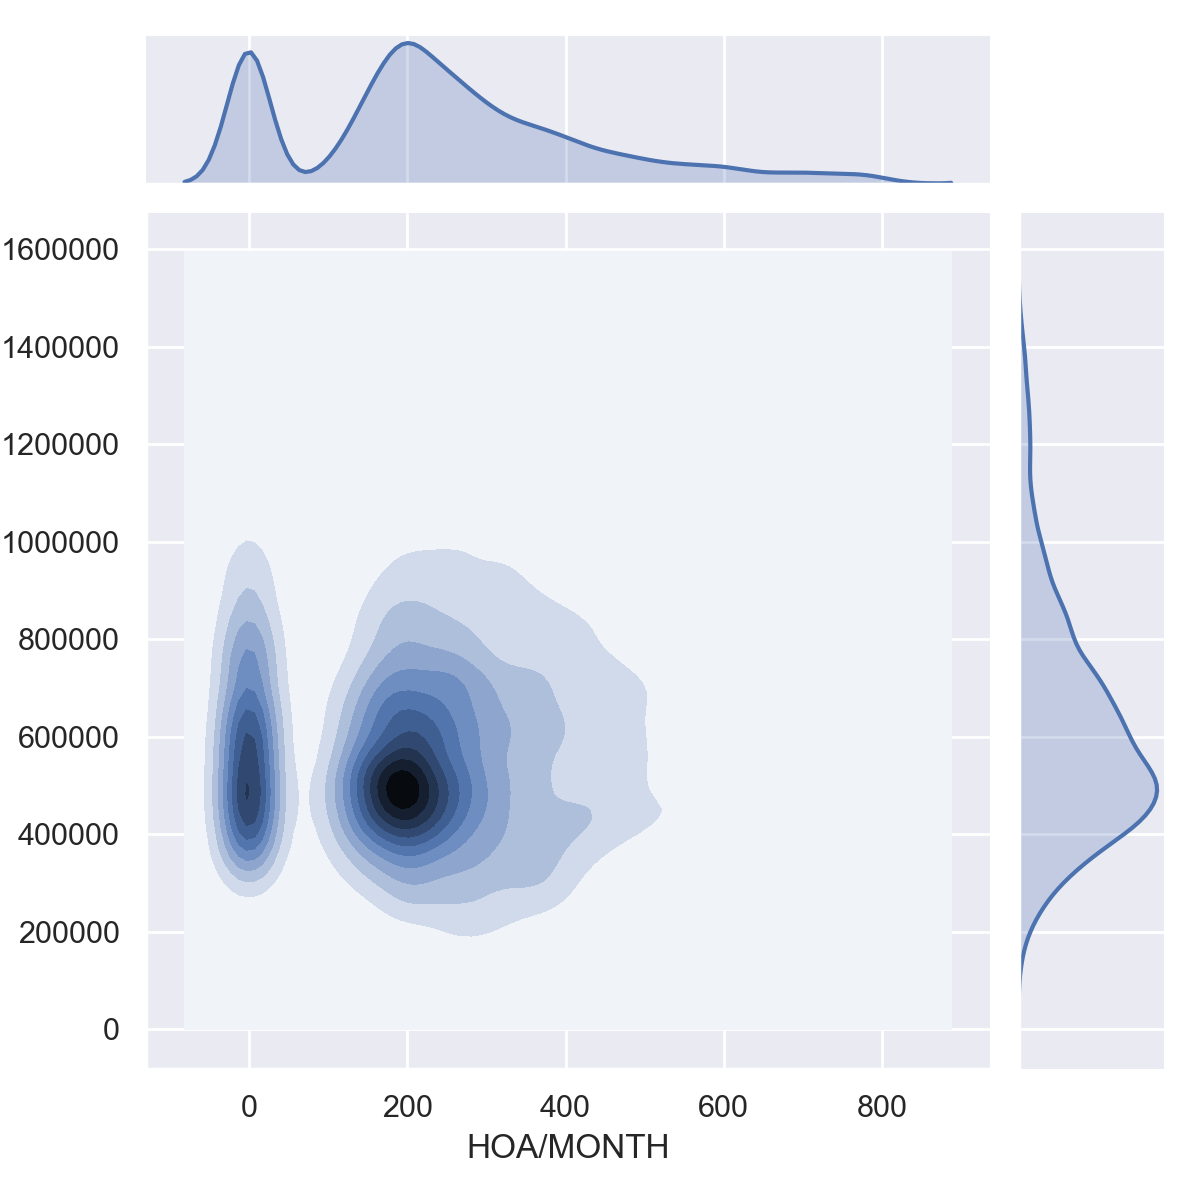

In [7]:
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns

sns.set()


df_joint = df[['HOA/MONTH','SOLD PRICE']]
#df_joint = np.log(df_joint)

sns.jointplot('HOA/MONTH', "SOLD PRICE", data=df_joint,
             #marginal_kws=dict(bins=100, rug=True),
             kind='kde')

plt.show()

<IPython.core.display.Javascript object>


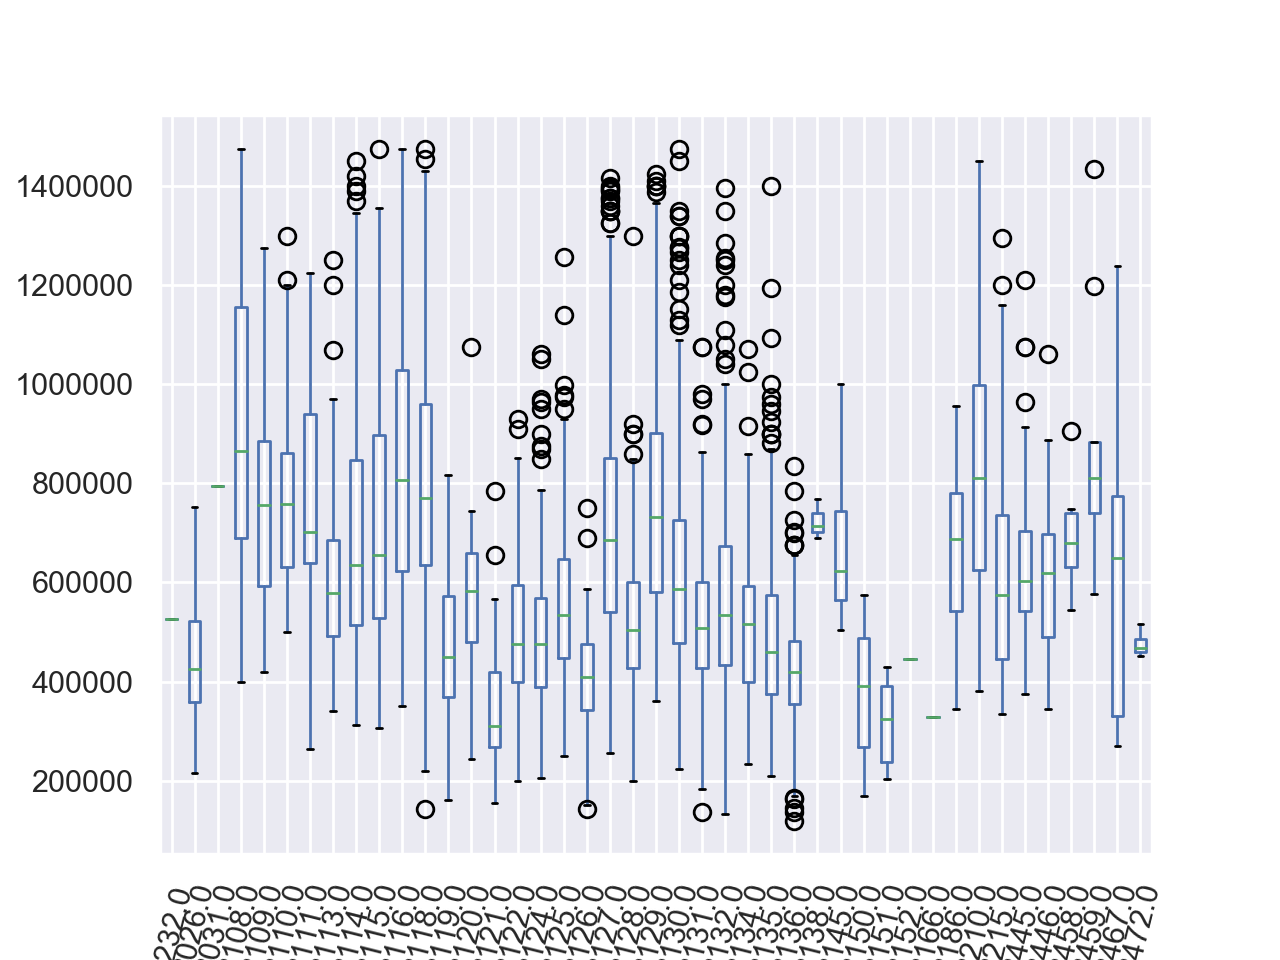

In [8]:
df_core = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH','ZIP OR POSTAL CODE']]

df_pivot = df_core.pivot(columns='ZIP OR POSTAL CODE',values='SOLD PRICE')

fig = plt.figure()
df_pivot.boxplot(column=df_pivot.columns.tolist())
plt.xticks(rotation=76)
plt.ylabel('SOLD PRICE')
plt.show()



<IPython.core.display.Javascript object>


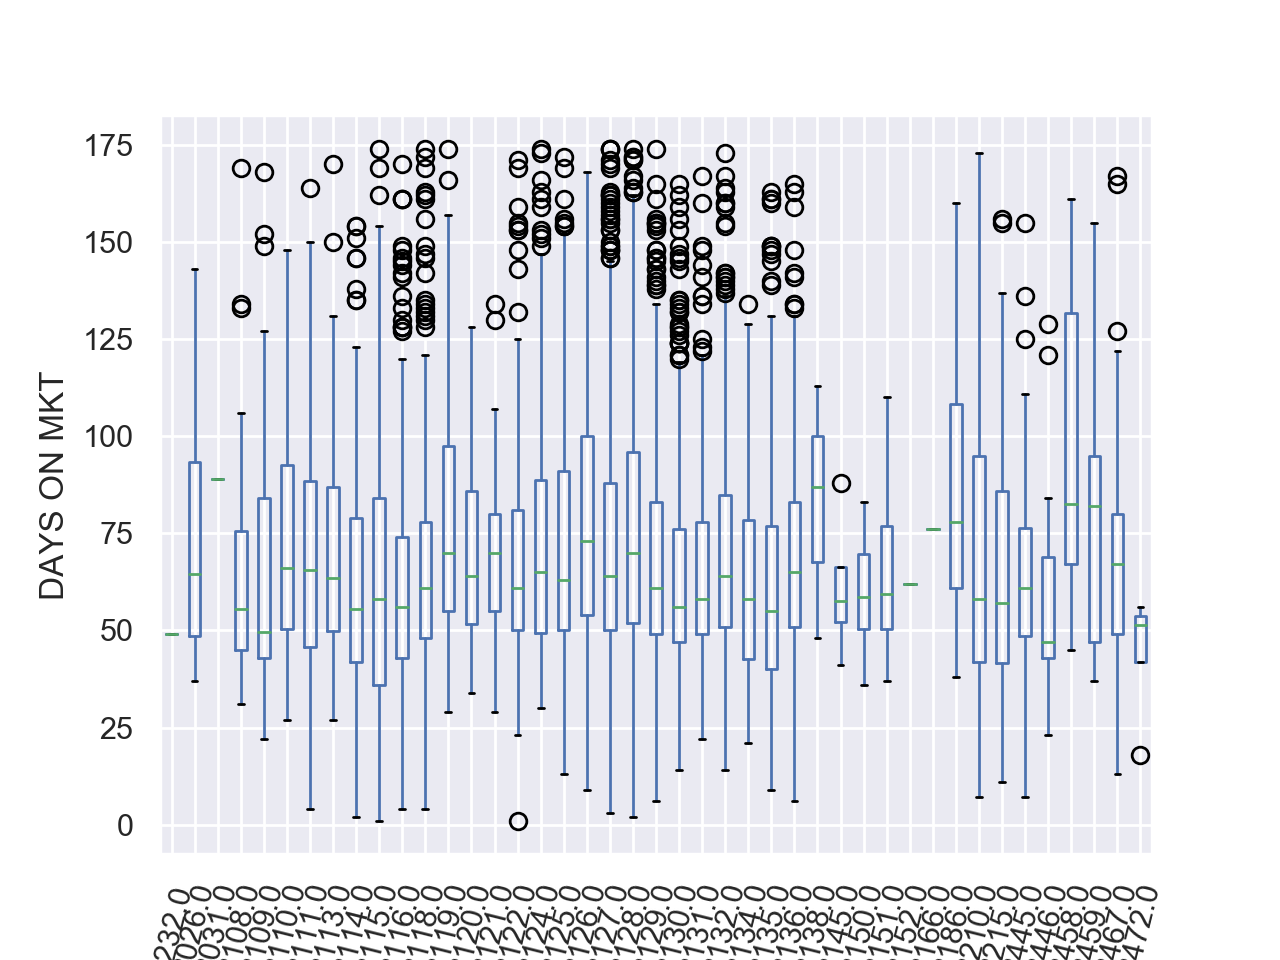

In [9]:
df_pivot = df_core.pivot(columns='ZIP OR POSTAL CODE',values='DAYS ON MKT')

fig = plt.figure()
df_pivot.boxplot(column=df_pivot.columns.tolist())
plt.xticks(rotation=76)
plt.ylabel('DAYS ON MKT')
plt.show()

1158


<IPython.core.display.Javascript object>


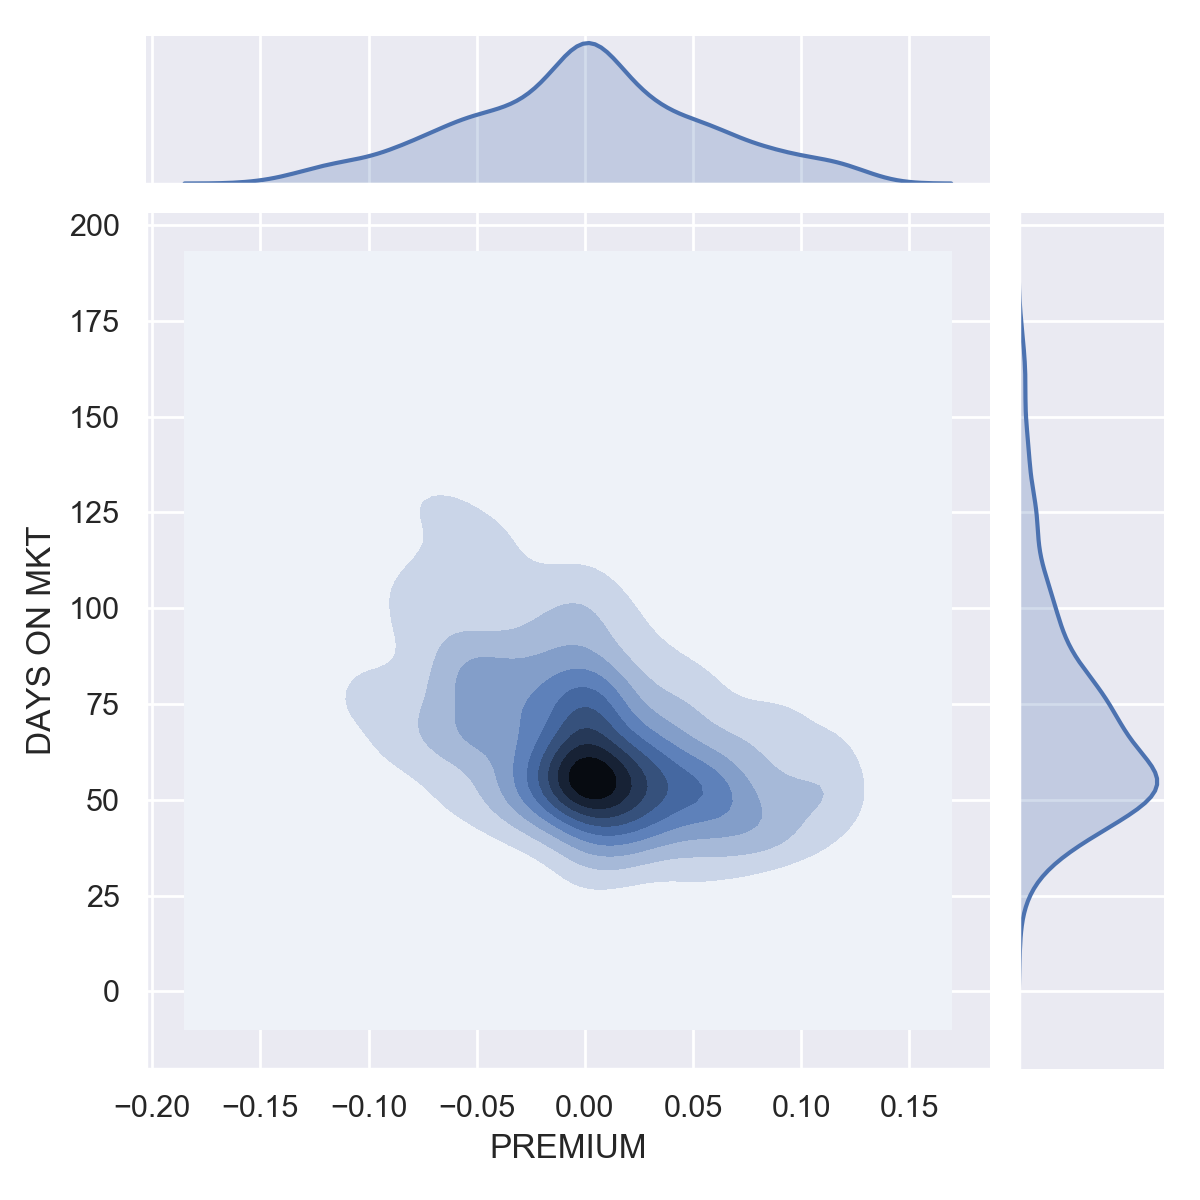

In [10]:
df_prop = df[df['PROPERTY TYPE']=='Single Family Residential']
print(len(df_prop))

sns.jointplot('PREMIUM', "DAYS ON MKT", data=df_prop,
             #marginal_kws=dict(bins=100, rug=True),
             kind='kde')

<IPython.core.display.Javascript object>


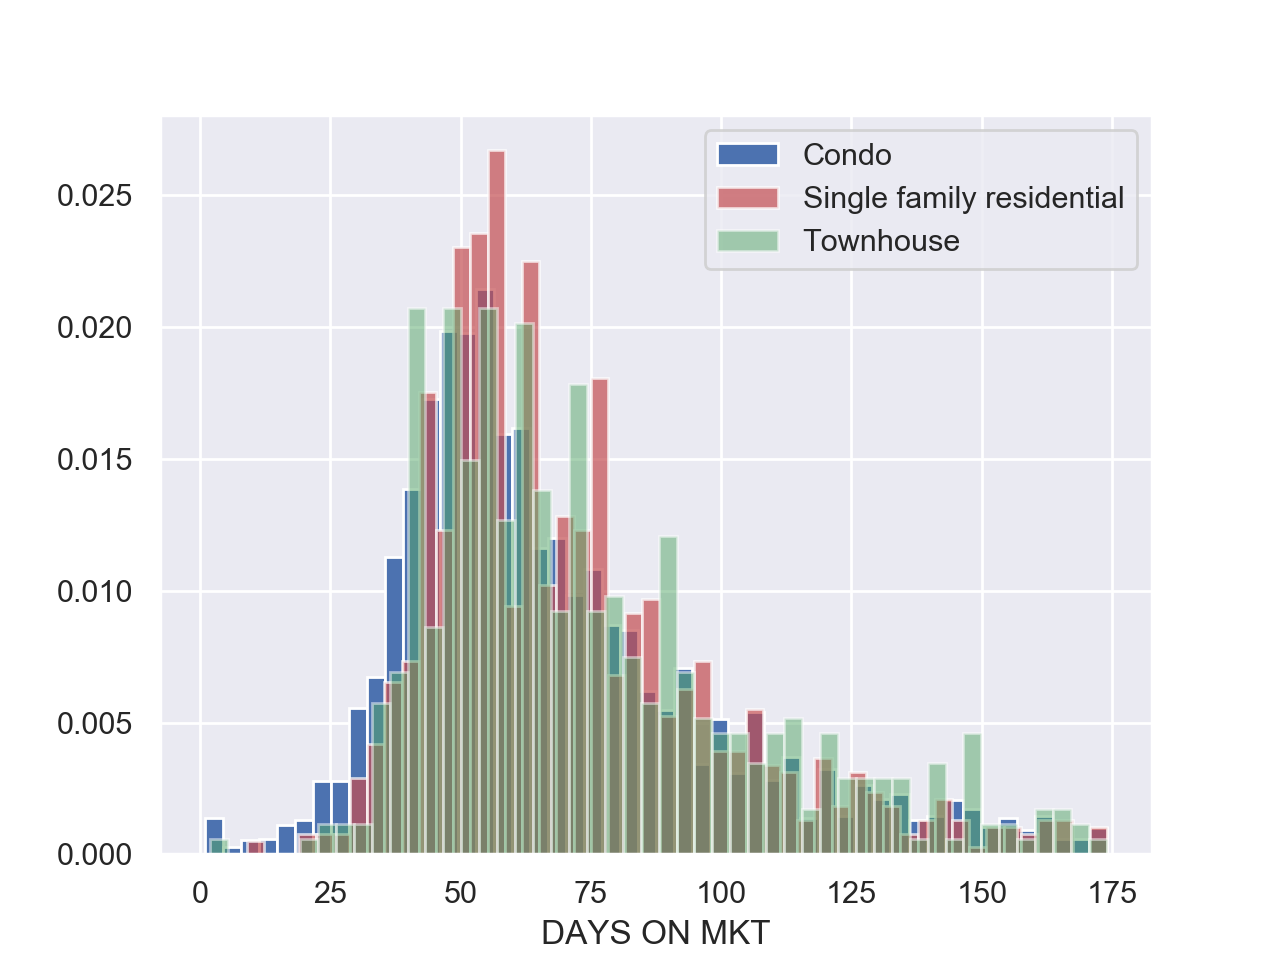

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


<IPython.core.display.Javascript object>


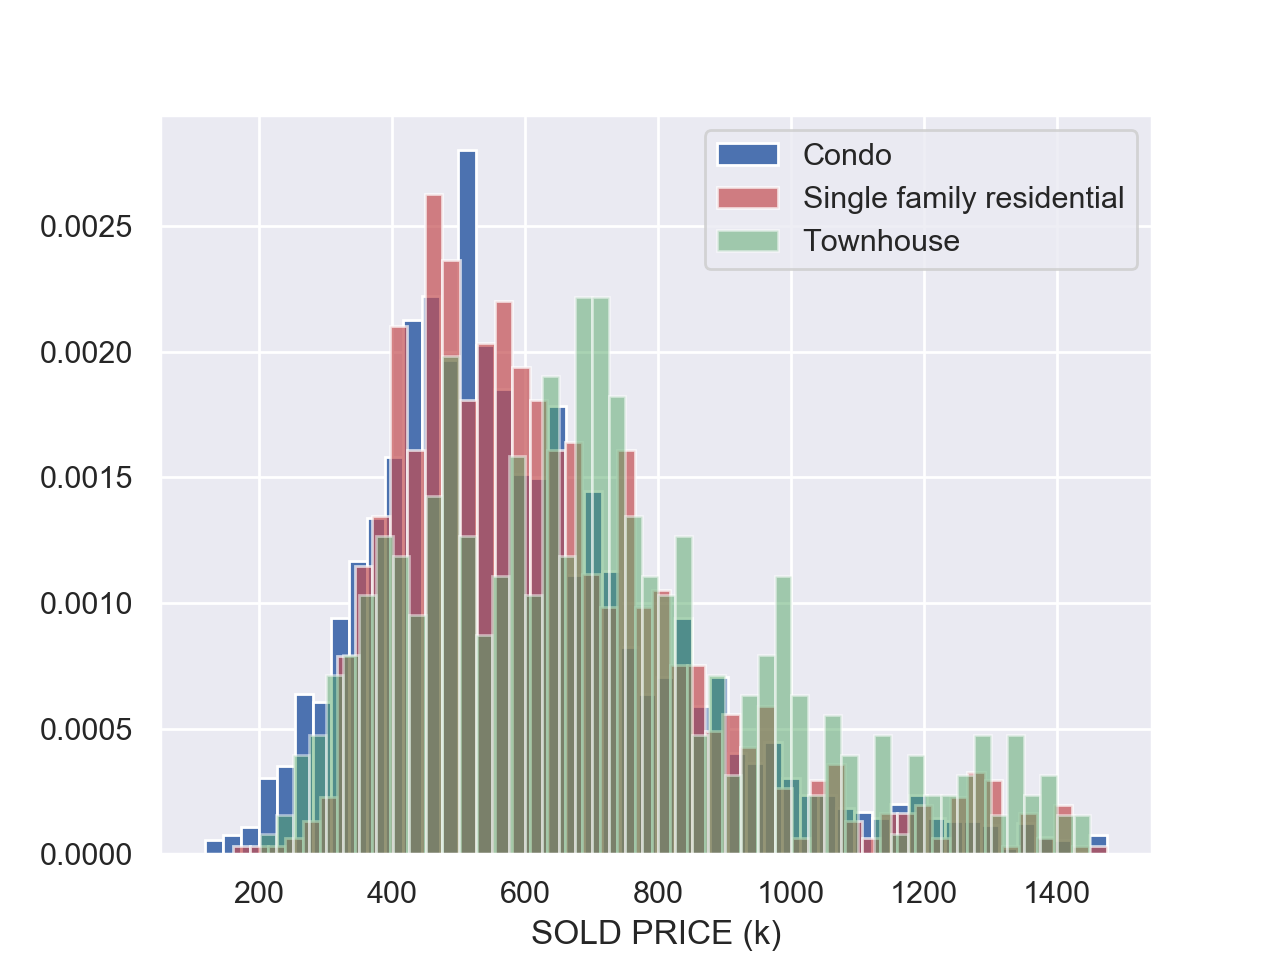

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


In [17]:
fig = plt.figure()
plt.hist(df[df['PROPERTY TYPE']=='Condo/Co-op']['DAYS ON MKT'],
         bins=50,color='b',label='Condo',normed=True)
plt.hist(df[df['PROPERTY TYPE']=='Single Family Residential']['DAYS ON MKT'],
         bins=50,color='r',label='Single family residential',normed=True,alpha=0.7)
plt.hist(df[df['PROPERTY TYPE']=='Townhouse']['DAYS ON MKT'],
         bins=50,color='g',label='Townhouse',normed=True,alpha=0.5)
plt.legend(loc='best')
plt.xlabel('DAYS ON MKT')
plt.draw()

fig = plt.figure()
plt.hist(df[df['PROPERTY TYPE']=='Condo/Co-op']['SOLD PRICE']/1000,
         bins=50,color='b',label='Condo',normed=True)
plt.hist(df[df['PROPERTY TYPE']=='Single Family Residential']['SOLD PRICE']/1000,
         bins=50,color='r',label='Single family residential',normed=True,alpha=0.7)
plt.hist(df[df['PROPERTY TYPE']=='Townhouse']['SOLD PRICE']/1000,
         bins=50,color='g',label='Townhouse',normed=True,alpha=0.5)
plt.legend(loc='best')
plt.xlabel('SOLD PRICE (k)')
plt.show()


In [21]:
from scipy.stats import ks_2samp

days_on_mkt_ks_p_values = np.zeros((3,3))
sold_price_ks_p_values = np.zeros((3,3))
for i,i_prop in enumerate(['Condo/Co-op','Single Family Residential','Townhouse']):
    for j,j_prop in enumerate(['Condo/Co-op','Single Family Residential','Townhouse']):
        days_on_mkt_ks_p_values[i][j] = ks_2samp(df[df['PROPERTY TYPE']==i_prop]['DAYS ON MKT'].values,
                                                 df[df['PROPERTY TYPE']==j_prop]['DAYS ON MKT'].values)[1]
        sold_price_ks_p_values[i][j] = ks_2samp(df[df['PROPERTY TYPE']==i_prop]['SOLD PRICE'].values,
                                                df[df['PROPERTY TYPE']==j_prop]['SOLD PRICE'].values)[1]

print('DAYS OF MKT KS p-value')
print(days_on_mkt_ks_p_values)
print('SOLD PRICE KS p-value')
print(sold_price_ks_p_values)

DAYS OF MKT KS p-value
[[1.00000000e+00 6.09555812e-08 4.11426126e-05]
 [6.09555812e-08 1.00000000e+00 8.79302376e-02]
 [4.11426126e-05 8.79302376e-02 1.00000000e+00]]
SOLD PRICE KS p-value
[[1.00000000e+00 1.25304896e-04 1.12143497e-18]
 [1.25304896e-04 1.00000000e+00 1.64519065e-10]
 [1.12143497e-18 1.64519065e-10 1.00000000e+00]]


<IPython.core.display.Javascript object>


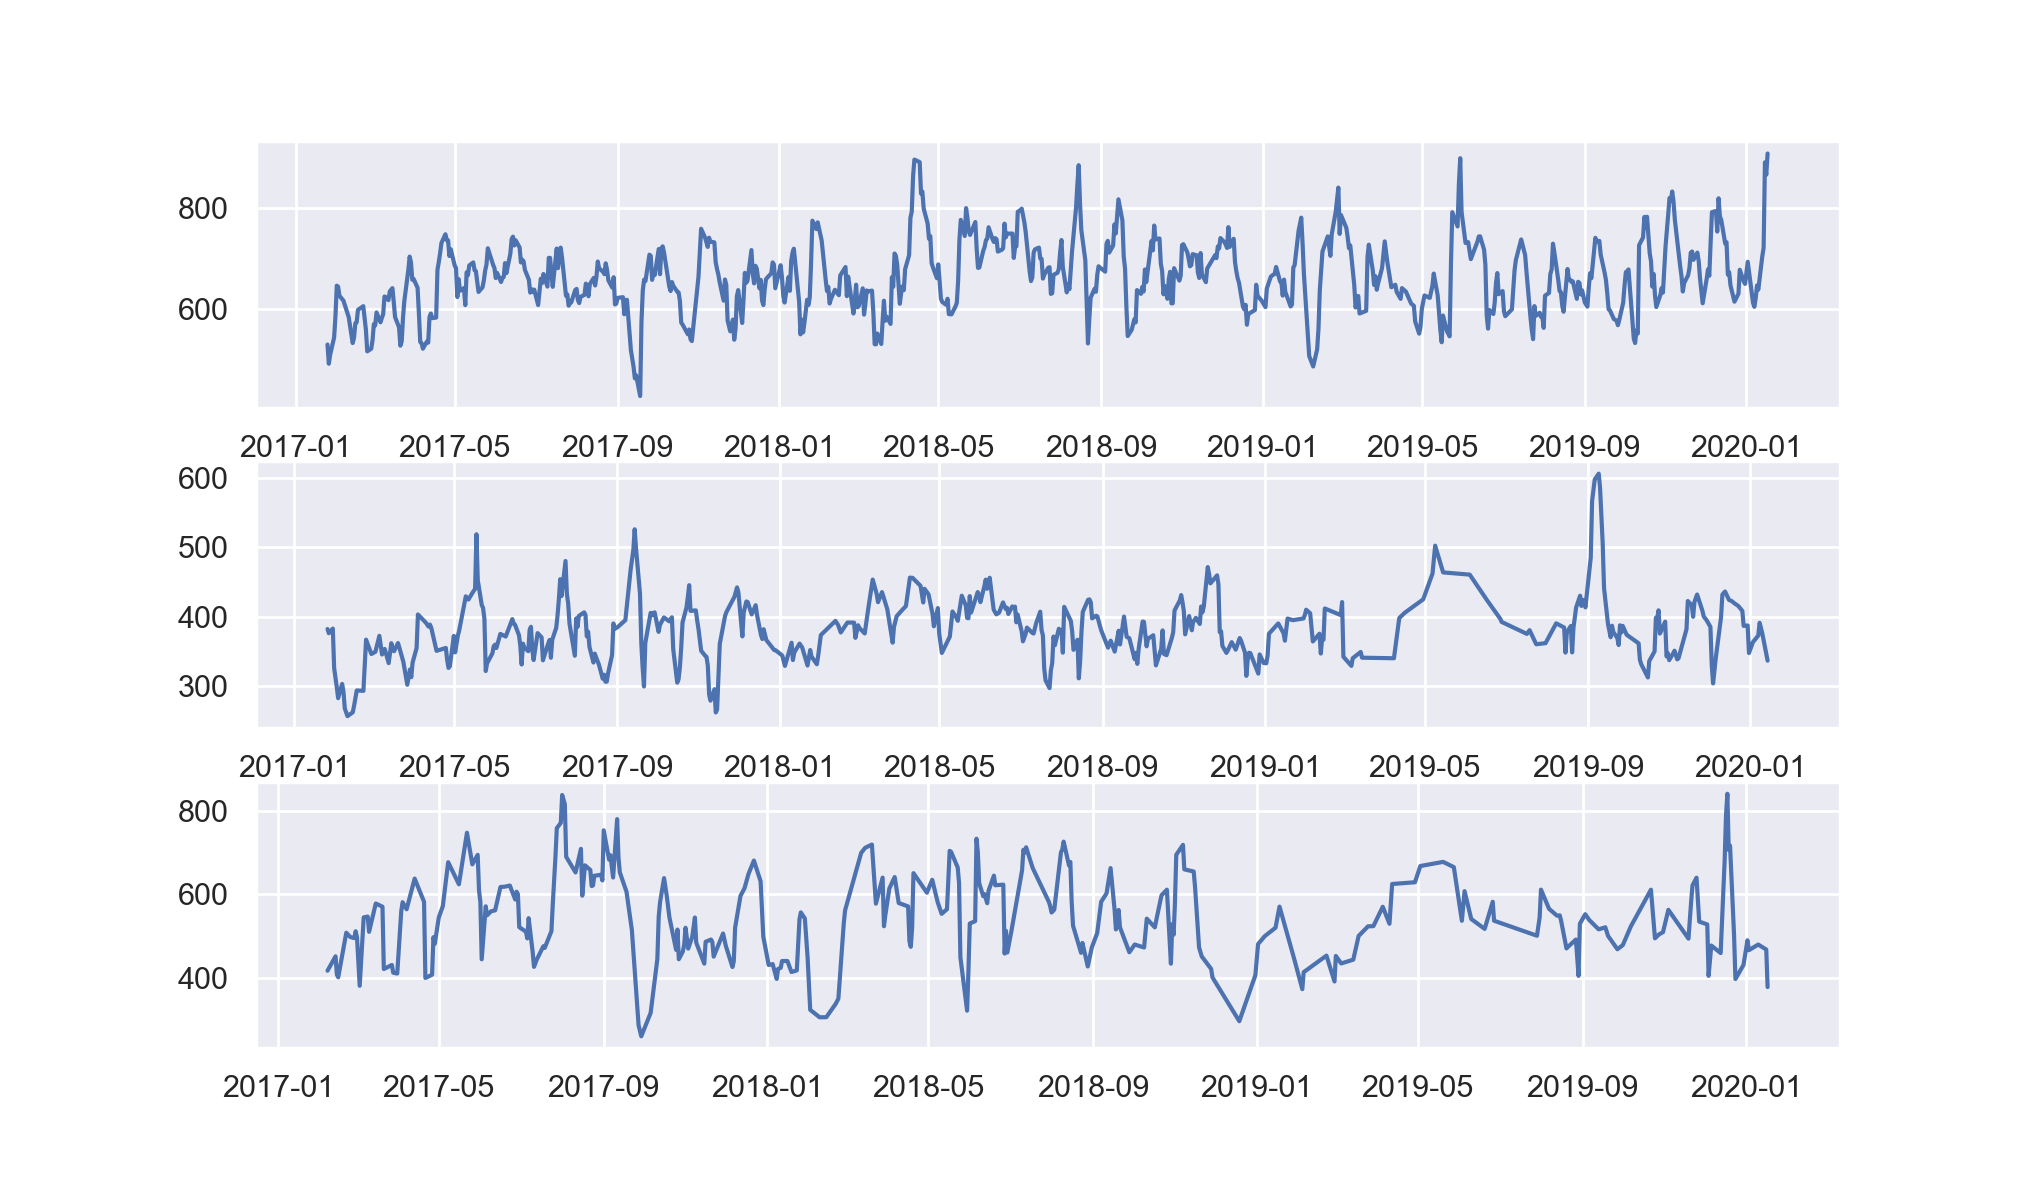

In [38]:
df = df.sort_values('SOLD DATE')

df_condo = df[df['PROPERTY TYPE'] == 'Condo/Co-op']
df_sfr = df[df['PROPERTY TYPE'] == 'Single Family Residential']
df_townhouse = df[df['PROPERTY TYPE'] == 'Townhouse']


df_condo_price_per_sqft = df_condo[['SOLD DATE','$/SQUARE FEET']].groupby('SOLD DATE').mean()
df_condo_rolling_price_per_sqft = df_condo_price_per_sqft.rolling(5).mean()

df_sfr_price_per_sqft = df_sfr[['SOLD DATE','$/SQUARE FEET']].groupby('SOLD DATE').mean()
df_sfr_rolling_price_per_sqft = df_sfr_price_per_sqft.rolling(5).mean()

df_townhouse_price_per_sqft = df_townhouse[['SOLD DATE','$/SQUARE FEET']].groupby('SOLD DATE').mean()
df_townhouse_rolling_price_per_sqft = df_townhouse_price_per_sqft.rolling(5).mean()

fig = plt.figure()
ax = fig.add_subplot(3,1,1)
plt.plot(df_condo_rolling_price_per_sqft.index,df_condo_rolling_price_per_sqft['$/SQUARE FEET'])

ax = fig.add_subplot(3,1,2)
plt.plot(df_sfr_rolling_price_per_sqft.index,df_sfr_rolling_price_per_sqft['$/SQUARE FEET'])

ax = fig.add_subplot(3,1,3)
plt.plot(df_townhouse_rolling_price_per_sqft.index,df_townhouse_rolling_price_per_sqft['$/SQUARE FEET'])
plt.show()